In [ ]:
import os
from pathlib import Path
from operator import itemgetter
import pickle
import pydicom
import pandas
from time import time

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, LineString, GeometryCollection, Point, MultiPoint
from shapely.affinity import translate

from catch_converter.parse_contours import parse_cvi42ws
from LazyLuna.Mini_LL import *
from LazyLuna.CATCH_utils import *
from LazyLuna.network_comparison_utils import *

In [ ]:
# basepaths
bp       = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases'
bp_annos = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Preds/MRUNet'
bp_cases = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Cases'
bp_imgs  = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Imgs'

In [ ]:
"""
imgsanno_paths = get_imgs_and_annotation_paths(bp_imgs, bp_annos)

cases = []
sax_cs_view   = SAX_CS_View()
for imgp, annop in imgsanno_paths:
    print(imgp, annop)
    st = time()
    case = Case(imgp, annop, os.path.basename(imgp), os.path.basename(bp_annos))
    case = sax_cs_view.customize_case(case)
    case.store(bp_cases)
    cases.append(case)
    print('Case customization took: ', time()-st, 'Case: ', case.reader_name, case.case_name)
"""

In [ ]:
case_paths = [p for p in os.listdir(bp_cases) if 'Annos' in p and p.endswith('.pickle')]
cases1 = sorted([pickle.load(open(os.path.join(bp_cases, p), 'rb')) for p in case_paths], key=lambda c:c.case_name)
case_paths = [p for p in os.listdir(bp_cases) if 'FCN' in p and p.endswith('.pickle')]
cases2 = sorted([pickle.load(open(os.path.join(bp_cases, p), 'rb')) for p in case_paths], key=lambda c:c.case_name)

In [ ]:
# get table of CRs, CR means and stdevs & wilcoxon test result diffs
df, stats, wilcox_tests = clinical_result_pandas_table(cases1, cases2, with_dices=True)
display(df)
print(stats['LVESV difference'])
print('Mean: ', stats['LVESV difference'].mean())
print(wilcox_tests['RVESV difference'])
pandas.DataFrame.to_csv(df, '/Users/dietrichhadler/Desktop/test_table.csv')

LVESP SAX LVES 0
RVESP SAX RVES 2
LVEDP SAX LVED 0
RVEDP SAX RVED 1
LVESP SAX LVES 1
RVESP SAX RVES 0
LVEDP SAX LVED 0
RVEDP SAX RVED 0
LVESP SAX LVES 0
RVESP SAX RVES 2
LVEDP SAX LVED 0
RVEDP SAX RVED 1
LVESP SAX LVES 1
RVESP SAX RVES 0
LVEDP SAX LVED 0
RVEDP SAX RVED 0
LVESP SAX LVES 0
RVESP SAX RVES 1
LVEDP SAX LVED 0
RVEDP SAX RVED 1
LVESP SAX LVES 0
RVESP SAX RVES 1
LVEDP SAX LVED 0
RVEDP SAX RVED 1


/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


NameError: name 'crvs_data' is not defined

NameError: name 'crvs_data' is not defined

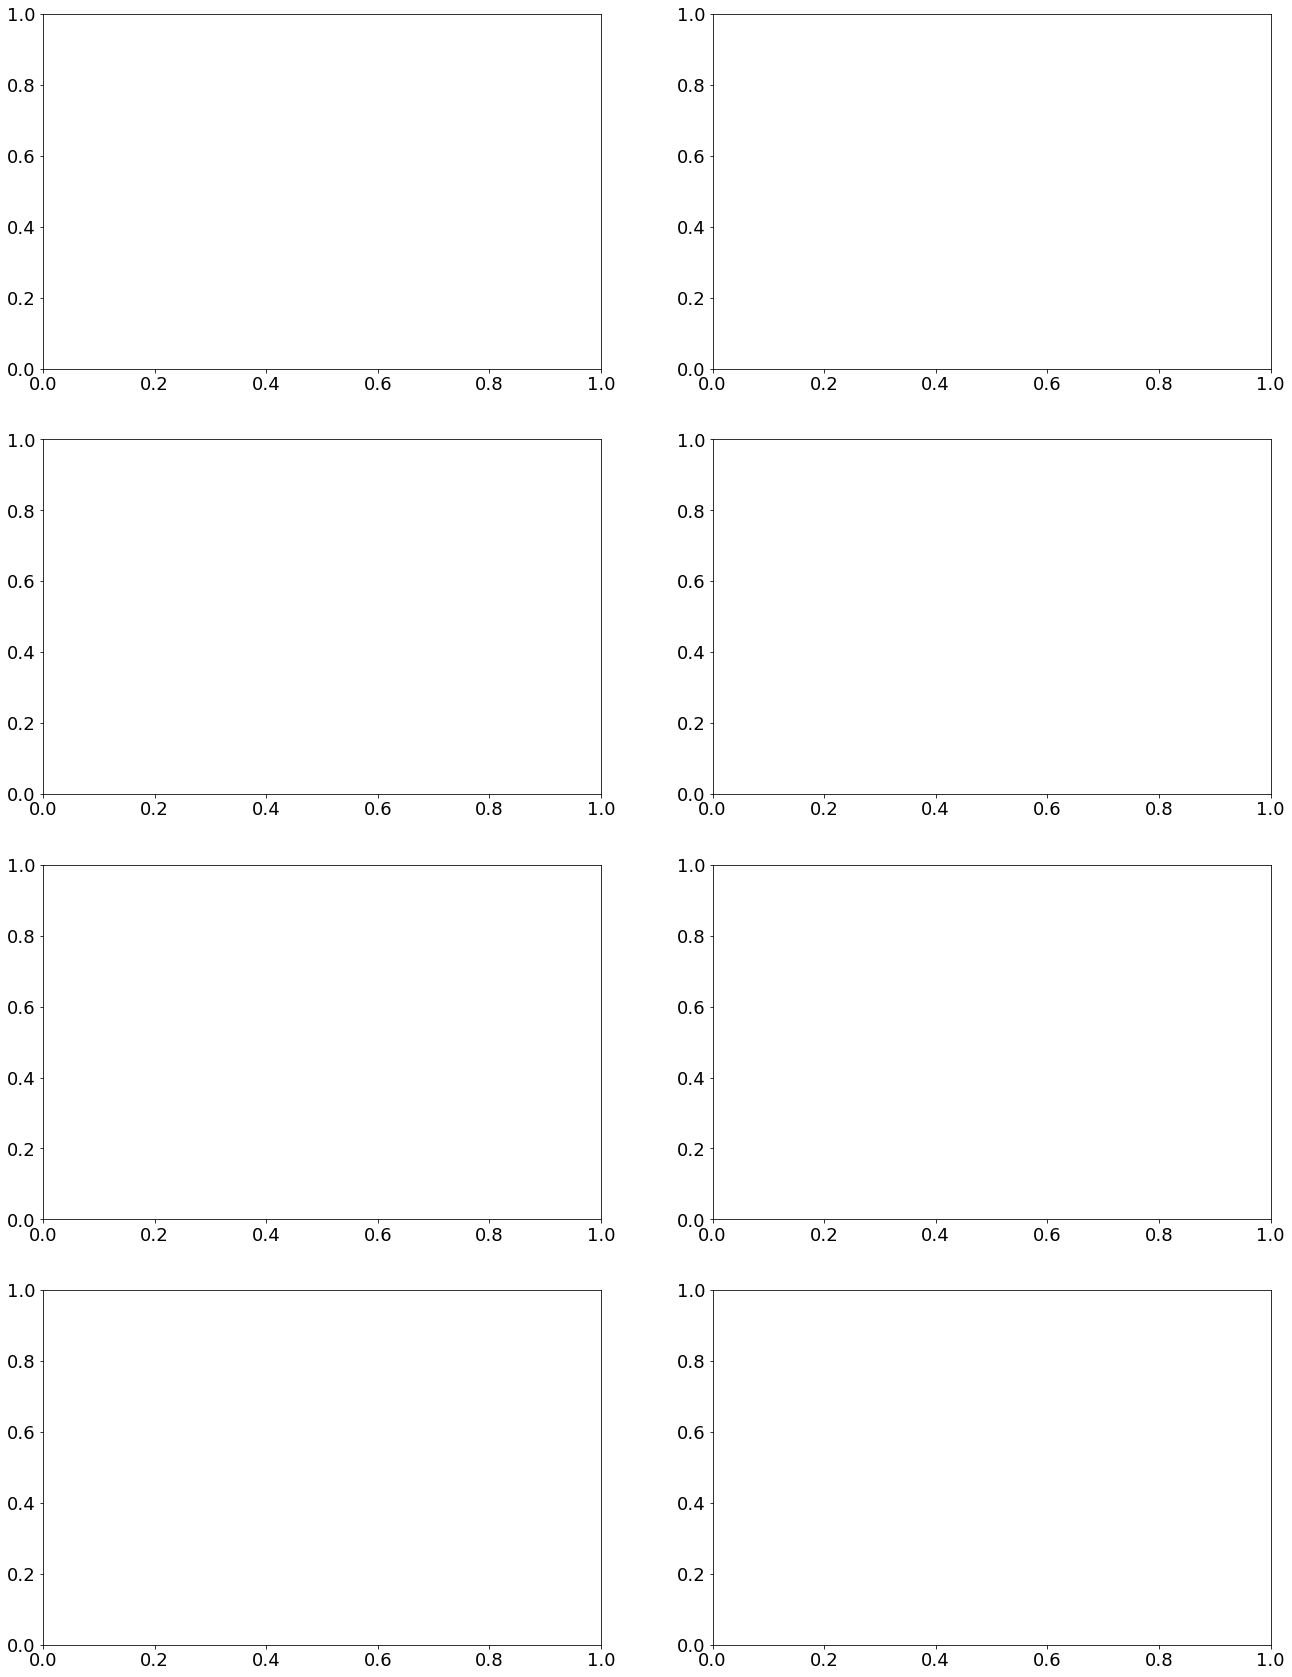

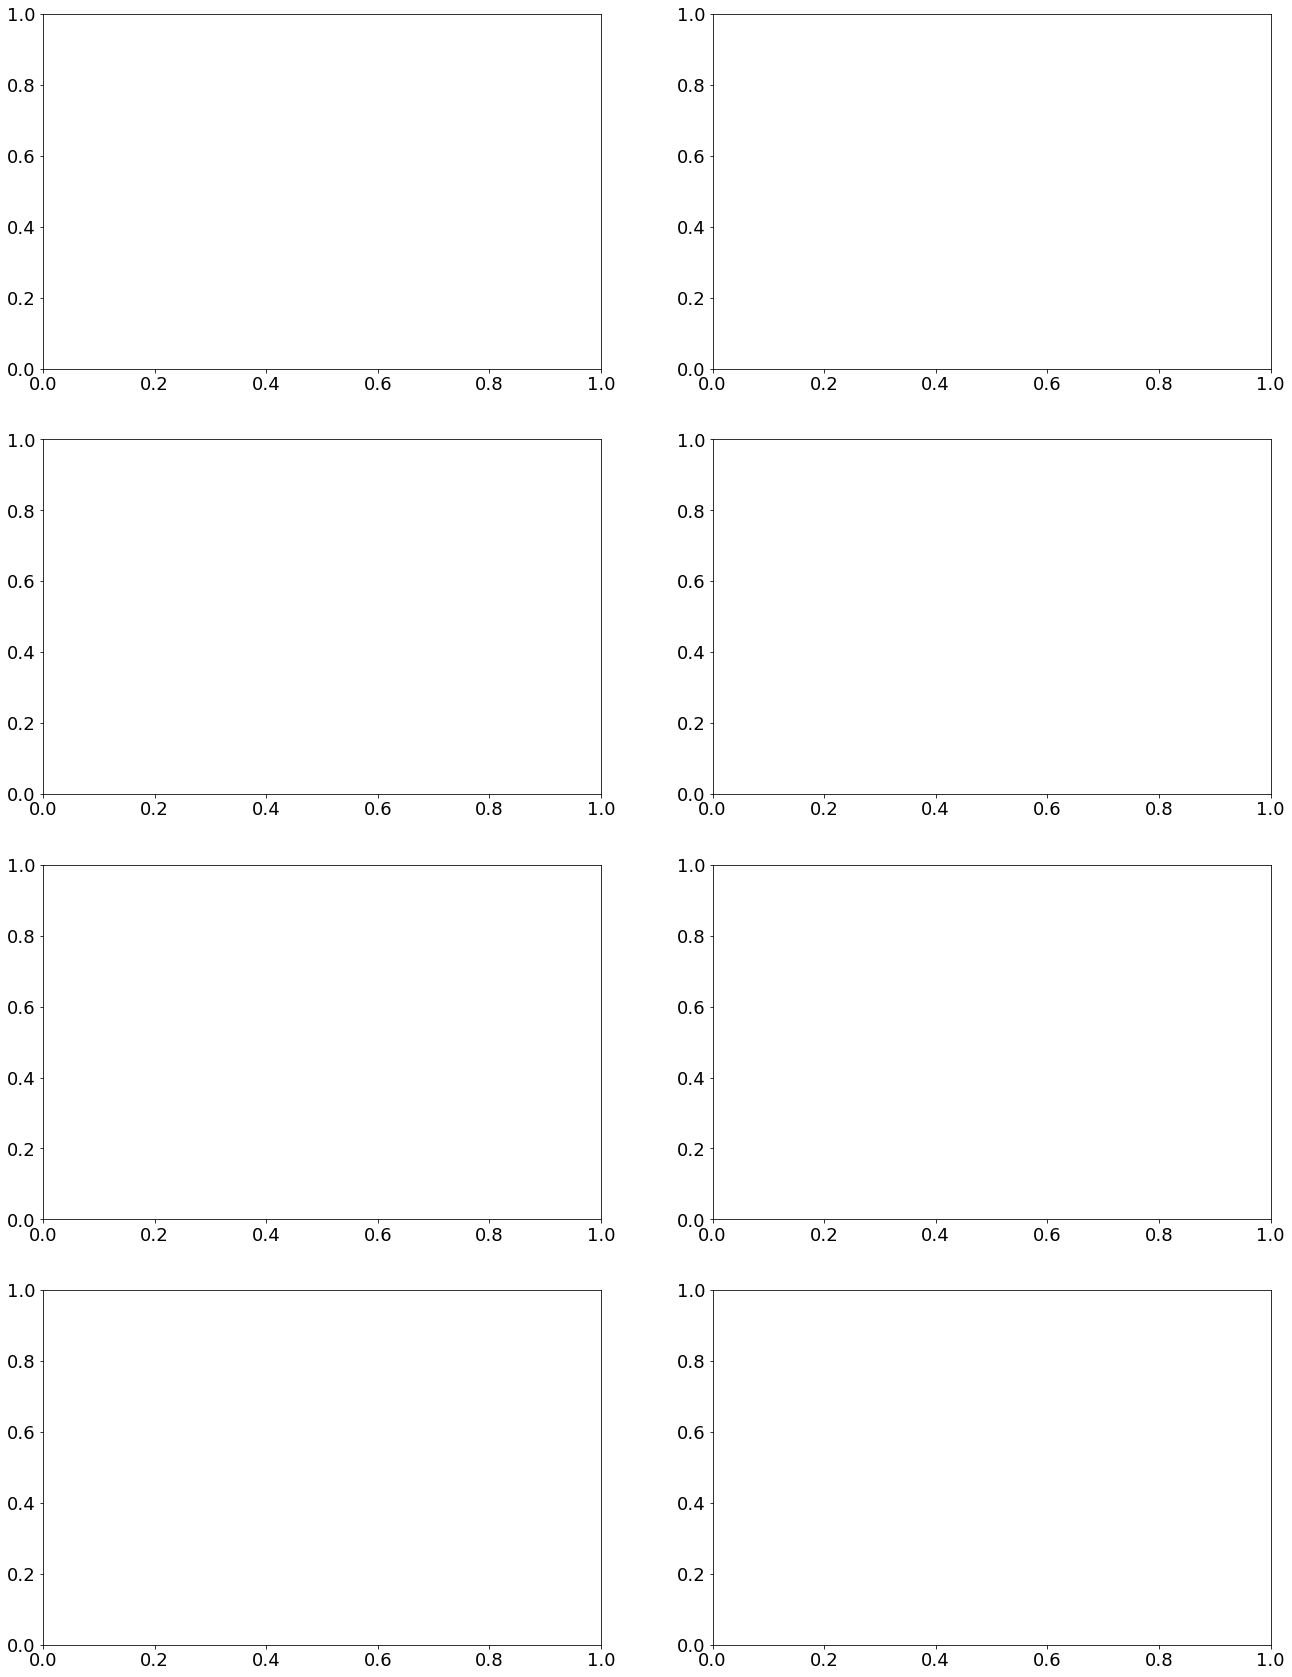

In [6]:
def SAX_candlelight_plot(gs_cases, name2cases):
    columns, rows    = 2, 4
    boxplot_palette  = sb.color_palette("Blues")
    boxplot_palette2 = sb.color_palette("Purples")
    swarm_palette = sb.color_palette(["#061C36", "#061C36"])
    font = {'family' : 'DejaVu Sans',
            'weight' : 'normal',
            'size'   : 18}
    plt.rc('font', **font)
    fig, axes = plt.subplots(rows, columns, figsize=(columns*11,(rows*7.5)))
    
    name2tables = dict()
    for n in name2cases.keys(): name2tables[n] = clinical_result_pandas_table(gs_cases, name2cases[n])
    
    j = 0
    for i, crv in enumerate(crvs_data):
        if i >= (rows*columns): continue
        while i >= rows: i-=rows
        axes[i][j].set_title(crv + " Error")
        sb.boxplot   (ax=axes[i][j], data=crvs_data[crv], palette=boxplot_palette, saturation=1, width=0.6)
        sb.swarmplot (ax=axes[i][j], data=crvs_data[crv], color="#061C36", alpha=1)
        axes[i][j].set_xticklabels([name2cases.keys()])
        axes[i][j].set_ylabel('[%]' if 'EF' in crv else '[ml]' if 'ESV' in crv or 'EDV' in crv else '[g]' )
        yabs_max = abs(max(axes[i][j].get_ylim(), key=abs))
        axes[i][j].set_ylim(ymin=-yabs_max, ymax=yabs_max)
        if i == (rows-1): j+=1

    ax = axes[3][1]
    ax.set_title('Dice')
    dicebp = sb.boxplot   (ax=ax, x="NetName", y="Dice", data=dice_data, hue="Segmented by both", width=0.8)
    sb.swarmplot (ax=ax, x="NetName", y="Dice", data=dice_data, hue="Segmented by both", palette=swarm_palette, dodge=True)
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_fc(boxplot_palette[3])
    handles[1].set_fc(boxplot_palette2[3])
    ax.legend(handles[:2], labels[:2], title="Segmented by both")
    ax.set_ylabel('[%]')
    ax.set_xlabel("")
    ax.set_ylim(ymin=70, ymax=95)

    for i, boxplot in enumerate(dicebp.artists):
        if i%2 == 0: boxplot.set_facecolor(boxplot_palette[i//2])
        else:        boxplot.set_facecolor(boxplot_palette2[i//2])

    sb.despine()
    plt.subplots_adjust(left=0.075, bottom=0.05, right=0.95, top=0.95, wspace=0.25, hspace=0.35)
    fig.savefig("candlelight_test.png", dpi=100, facecolor="#FFFFFF")
    
SAX_candlelight_plot(cases1, {'Unet':cases2})

In [ ]:
# Just showing some images
for c1,c2 in zip(cases1, cases2):
    print(c1.case_name, c2.case_name)
    lves1, lved1 = [c for c in c1.categories if 'ES' in c.name][0], [c for c in c1.categories if 'ED' in c.name][0]
    cat2 = [c for c in c2.categories][0]
    esp, edp = lves1.phase, lved1.phase
    for d in range(lves1.nr_slices):
        for p in [esp, edp]:
            print('Slice: ', d, ',  Phase: ', p)
            img1, anno1 = lves1.get_img(d, p), lves1.get_anno(d, p)
            img2, anno2 = cat2 .get_img(d, p), cat2 .get_anno(d, p)
            fig, axes = plt.subplots(1,5, figsize=(20,10))
            for i in range(5): axes[i].imshow(img1); axes[i].axis('off')
            anno1.plot_all_contour_outlines(axes[0])
            anno2.plot_all_contour_outlines(axes[1])
            anno1.plot_cont_comparison(axes[2], anno2, 'lv_endo')
            anno1.plot_cont_comparison(axes[3], anno2, 'lv_myo' )
            anno1.plot_cont_comparison(axes[4], anno2, 'rv_endo')
            fig.tight_layout()
            plt.show()